Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Medication Identification based on Pill Images

![headline image: image-based medication identification](pill_id_tutorial_head.jpg)

## Problem Overview

This AI tutorial focuses in an application of computer vision to help reducing medical errors. This is a very relevant problem since medical error is the [third most common cause of death in the US](https://www.bmj.com/content/353/bmj.i2139.full.pdf), instead of some disease. In specific, to avoid medication errors, it is important for patients, healthcare providers and first responders to know which medications are being taken and/or dispensed. For example, patients face challenges identifying pills when they are transferred to different containers, combined to a single container for convenience, or portioned into day-of-week pillboxes to simplify medication management. This is a common occurrence in elderly or chronic disease patients.

Throughout this notebook, we'll develop a simplified deep-learning application to reduce avoidable medication errors with their attendant risk by correctly identifying prescription medication based on pill images, which currently is a tedious and error-prone task. It details how to develop a model for prescription pill identification from a subset of pills from the mobile-quality images of the [NIH NLM Pill Image Recognition Challenge dataset](https://pir.nlm.nih.gov/challenge/). The steps presented here are a simplified model based on the work presented in this Nature Digital Medicine [article for Fast and accurate medication identification](https://www.nature.com/articles/s41746-019-0086-0) and accompanying [blog article in Nature community](https://npjdigitalmedcommunity.nature.com/users/211675-jessica-lundin/posts/44881-face-recognition-for-pills).

## Solution Overview

This example includes the creation and preparation of a workspace, the remote cluster to work as compute resource for model training, download and placing of training data into a storage account accessible during training, and the creation and use of a [PyTorch estimator](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-train-pytorch) to learn a pill-identification ConvNet from the data. One of the main benefits of using the Azure ML workspace is that it contains in a logical and structured manner all the compute resources, job and experiment management tools, result tracking dashboards and model prediction services that any data scientist performing machine learning development requires.

The notebook contains the following sections:

1. AML Workspace Setup and Create a Compute Target

2. Set the Pill Training Data in Azure Storage Accessible to the Workspace

3. Create Experiments and Submit a Training Run

4. Analyze Training Results

![Overview of model training on Azure ML](azureml_training_overview.png)

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.10


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`. Download **config.json** from your Azure ML workspace page in the Azure ML portal.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

Found the config file in: /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/config.json
pillid-example	westus2	pillid-example	westus2


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'pillid-example'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace. You can also create clusters from the portal.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "gpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses K80 VM. 
# Available GPUs: https://docs.microsoft.com/en-us/azure/virtual-machines/windows/sizes-gpu
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "Standard_NC6")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. gpu-cluster


You now have the necessary packages and compute resources to train a model in the cloud. 

## Explore data

Before you train a model, you need to understand the data that you are using to train it.  You also need to copy the data into the cloud so it can be accessed by your cloud training environment.  In this section you learn how to:

* Download the dataset
* Display some sample images
* Upload data to the cloud

### Download the  dataset

In 2016, the National Library of Medicine (NLM) of National Institutes of Health (NIH) hosted the Pill Image Recognition Challenge [NIH NLM Pill Image Recognition Challenge dataset](https://pir.nlm.nih.gov/challenge/). In this tutorial, we use a subset of the images for simplicity.

In [5]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

filename = "pill_recognition_azureml_sample.zip"
local_path = os.path.join(data_folder, filename)
urllib.request.urlretrieve('https://pillidwus2.blob.core.windows.net/public/' + filename, filename=local_path)

('/home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample.zip',
 <http.client.HTTPMessage at 0x7f40e2ab69b0>)

In [6]:
# This will take a couple of minutes to unzip the image files
from zipfile import ZipFile

with ZipFile(local_path, 'r') as zf:
    zf.extractall(data_folder)

### Display some sample images

Use `matplotlib` to plot random images from the downloaded dataset.

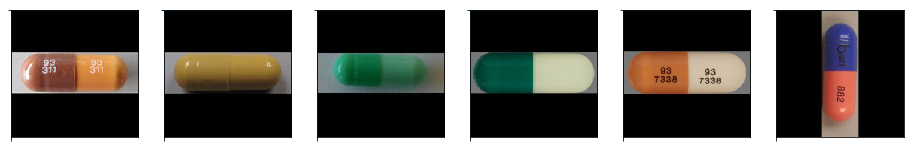

In [7]:
from glob import glob

imgs = glob(os.path.join(data_folder, "pill_recognition_azureml_sample", "imgs", "*.jpg"))

# now let's show some randomly chosen images
sample_size = 6
plt.figure(figsize = (16, 6))
for i, p in enumerate(np.random.permutation(imgs)[:sample_size]):
    plt.subplot(1, sample_size, i + 1)
    plt.axhline('')
    plt.axvline('')
    img = plt.imread(p)
    plt.imshow(img)

plt.show()

Now you have an idea of what these images look like and the expected prediction outcome.

### Upload data to the cloud (Azure blob storage)

Now make the data accessible remotely by uploading that data from your local machine into Azure so it can be accessed for remote training. The datastore is a convenient construct associated with your workspace for you to upload/download data, and interact with it from your remote compute targets. It is backed by Azure blob storage account.

The files are uploaded into a directory named `pillid_example` at the root of the datastore.

Alternatively, you can upload the files using [Azure Storage Explorer](https://azure.microsoft.com/en-us/features/storage-explorer/) or mounting the blob as a file system. You cna get the blob information from the Azure-ML workspace page.

- [How to mount Blob storage as a file system with blobfuse](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-how-to-mount-container-linux)

In [8]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir=data_folder, target_path='pillid_example', overwrite=True, show_progress=True)

AzureBlob pillidexample7956241498 azureml-blobstore-19fea664-4c89-4731-a84b-9ce5d23c8eae
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample.zip
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/folds/C48336_5folds_0.csv
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/folds/C48336_5folds_1.csv
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/folds/C48336_5folds_2.csv
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/folds/C48336_5folds_3.csv
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/folds/C48336_5folds_4.c

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-0810-01_PART_1_OF_1_CHAL10_SB_34271A58.jpg, 48 files out of an estimated total of 1164
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-0812-01_PART_1_OF_1_CHAL10_SF_2D2316D8.jpg, 49 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-3147-01_PART_1_OF_1_CHAL10_SB_C51962CB.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-0811-01_PART_1_OF_1_CHAL10_SF_15270A98.jpg, 50 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-3129-01_PART_1_OF_1_CHAL10_SF_B32DD9FE.jpg, 74 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-4030-01_PART_1_OF_1_CHAL10_SF_04268274.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-3167-53_PART_1_OF_1_CHAL10_SB_10270828.jpg, 75 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-4030-01_PART_1_OF_1_CHAL10_SF_20271038.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-3165-01_PART_1_OF_1_CHAL10_SB_19270CA8

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-4356-01_PART_1_OF_1_CHAL10_SB_0E210728.jpg, 111 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-7198-56_PART_1_OF_1_CHAL10_SF_C429620B.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-5256-68_PART_1_OF_1_CHAL10_SF_15268A84.jpg, 112 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-7227-72_PART_1_OF_1_CHAL10_SB_CC306663.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-4336-01_PART_1_OF_1_CHAL10_SB_CA2DE5

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-7335-06_PART_1_OF_1_CHAL10_SF_C526E2A7.jpg, 135 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-7437-01_PART_1_OF_1_CHAL10_SF_80304022.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-7370-01_PART_1_OF_1_CHAL10_SB_C419623B.jpg, 136 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-7438-01_PART_1_OF_1_CHAL10_SB_84304232.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00093-4336-01_PART_1_OF_1_CHAL10_SF_CA2DE5

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00378-2537-01_PART_1_OF_1_CHAL10_SB_04268244.jpg, 179 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00555-0323-02_PART_1_OF_1_CHAL10_SF_E72B73EB.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00378-0143-01_PART_1_OF_1_CHAL10_SF_8221411A.jpg, 180 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00555-0324-02_PART_1_OF_1_CHAL10_SB_DE2B6F6B.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00143-3367-01_PART_1_OF_1_CHAL10_SB_821C41

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00591-5694-01_PART_1_OF_1_CHAL10_SB_F90E7C93.jpg, 228 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1008.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00777-3105-02_PART_1_OF_1_CHAL10_SF_061C8364.jpg, 229 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/101.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00591-5694-01_PART_1_OF_1_CHAL10_SF_F90E7C93.jpg, 230 files out of an estimated total of 1164
Uploading /home/naotous/pilli

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00555-1055-86_PART_1_OF_1_CHAL10_SB_E33071D3.jpg, 251 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1094.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/00781-2054-01_PART_1_OF_1_CHAL10_SB_A30ED1E6.jpg, 252 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1098.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1048.jpg, 253 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1031.jpg, 286 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1274.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1210.jpg, 287 files out of an estimated total of 1164
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1165.jpg, 288 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1286.jpg
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1291.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1456.jpg, 334 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1534.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1434.jpg, 335 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1537.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1315.jpg, 336 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1538.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1534.jpg, 359 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1639.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1455.jpg, 360 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1644.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1541.jpg, 361 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1647.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/14.jpg, 386 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1775.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1579.jpg, 387 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1777.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1665.jpg, 388 files out of an estimated total of 1164
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1568.jpg, 389 fi

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1713.jpg, 416 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1991.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1802.jpg, 417 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1995.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1794.jpg, 418 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2014.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2103.jpg, 457 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2261.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1851.jpg, 458 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2264.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/1845.jpg, 459 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2266.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/225.jpg, 484 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2371.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2120.jpg, 485 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2377.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2222.jpg, 486 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2388.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2485.jpg, 531 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2636.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2471.jpg, 532 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2638.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2520.jpg, 533 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2655.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/267.jpg, 562 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2800.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2659.jpg, 563 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2805.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2695.jpg, 564 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2809.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2937.jpg, 617 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3039.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/295.jpg, 618 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3042.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2959.jpg, 619 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3044.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2960.jpg, 653 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3232.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2863.jpg, 654 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3236.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/2999.jpg, 655 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3240.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/311.jpg, 701 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3485.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3098.jpg, 702 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3493.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3120.jpg, 703 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3496.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3493.jpg, 726 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3611.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3529.jpg, 727 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3630.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/351.jpg, 728 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3631.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/354.jpg, 757 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3768.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3658.jpg, 758 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3773.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3669.jpg, 759 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3802.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3742.jpg, 796 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3992.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3690.jpg, 797 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3997.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/3847.jpg, 798 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4009.jpg
Uplo

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4116.jpg, 846 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4226.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/413.jpg, 847 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4227.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4205.jpg, 848 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4235.jpg
Uploa

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4273.jpg, 876 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4396.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/407.jpg, 877 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4402.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4294.jpg, 878 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/441.jpg
Upload

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4534.jpg, 927 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4684.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/460.jpg, 928 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4690.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/463.jpg, 929 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4692.jpg
Upload

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4675.jpg, 985 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4992.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/481.jpg, 986 files out of an estimated total of 1164
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4903.jpg, 987 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4998.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4934.jpg, 988 f

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4887.jpg, 1011 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/531.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/50111-0647-01_PART_1_OF_1_CHAL10_SB_893044A2.jpg, 1012 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/532.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/50111-0648-01_PART_1_OF_1_CHAL10_SB_6E303721.jpg, 1013 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligenc

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/4810.jpg, 1046 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/619.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/53014-0404-10_PART_1_OF_1_CHAL10_SB_2D1C9684.jpg, 1047 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/62037-0640-30_PART_1_OF_1_CHAL10_SB_19268CC4.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/53.jpg, 1048 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence

Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/685.jpg, 1103 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/844.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/686.jpg, 1104 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/856.jpg
Uploaded /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/734.jpg, 1105 files out of an estimated total of 1164
Uploading /home/naotous/pillidfast/users/naotous/health-intelligence/PillID/azureml_showcase/data/pill_recognition_azureml_sample/imgs/859.jpg
Uploade

$AZUREML_DATAREFERENCE_20c8d2b8069e44b59b2d25884299deb0

## Training script

The main training script is `scripts/train.py`. The training script takes an argument to find the directory containing the data. When you submit the job later, you point to the datastore for this argument: `parser.add_argument('--data_root_dir')`.

The only Azure-ML related codes in the script are for metrics tracking:
```
import azureml.core.run
# get hold of the current Azure-ML run
run = azureml.core.run.Run.get_context()

run.log('train_loss', train_loss)
```
More details [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-track-experiments) for tracking your experiments and monitoring metrics.

When the script is running outside Azure ML (e.g. local VM), `run.log` just outputs to the stdout.

### Running/Debugging the script without Azure ML

- You can use the same script without any modifications
 - Azure-ML related lines (e.g. `run.log`) don't throws errors when the script is running outside Azure-ML clusters.
- Use the same Docker image
 - You can use the same Docker image that you use for Azure ML. You can upload your custom Docker image to Docker Hub or Azure Docker Registry.
- Use the same data
  - The script takes the path to the directory as an argument (`--data_root_dir`). You can [mount the blob as a file system on your Linux VM](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-how-to-mount-container-linux), then you can test your script using the same files.

### Create an estimator

An estimator object is used to submit the run. Azure Machine Learning has pre-configured estimators for common machine learning frameworks, as well as generic Estimator. In this tutorial, we use the generic Estimator and specify a custom Docker image from Docker Hub.

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script 

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the datastore (`ds.path('pillid_example/pill_recognition_azureml_sampl').as_mount()`).

In [9]:
from azureml.core import RunConfiguration

rc = RunConfiguration()
rc.max_run_duration_seconds = 60 * 60
rc.environment.docker.enabled = True

# In this example, we use a public image on Docker Hub
# You can build your custom image and push it to Docker Hub or Azure Docker Registry.
rc.environment.docker.base_image = "naotous/pytorch-image:py36torch041"
rc.environment.docker.gpu_support = True

# provide username/password if it's private
#rc.environment.docker.base_image_registry.address = ""
#rc.environment.docker.base_image_registry.username = ""
#rc.environment.docker.base_image_registry.password = ""

# don't let the system build a new conda environment
rc.environment.python.user_managed_dependencies = True
# point to an existing python environment in the Docker image
rc.environment.python.interpreter_path = '/app/miniconda/envs/py36/bin/python'

from azureml.train.estimator import Estimator

script_params = {'--data_root_dir': ds.path('pillid_example/pill_recognition_azureml_sample').as_mount()}

est = Estimator(source_directory='scripts',
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                environment_definition=rc.environment)

This is what the mounting point looks like:

In [10]:
print(ds.path('pillid_example/pill_recognition_azureml_sample').as_mount())

$AZUREML_DATAREFERENCE_f0a38d8b75f042cb86aaf557a60cf39a


### Submit the job to the cluster

Run the experiment by submitting the estimator object. And you can navigate to Azure portal to monitor the run.

In [11]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
pillid-example,pillid-example_1561769797_b77e182c,azureml.scriptrun,Starting,Link to Azure Portal,Link to Documentation


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**.

Here is what's happening while you wait:

- **Docker image preparation**: A Docker image is downloaded from the registry specified by the estimator. 

  This stage happens once for each Python environment since the container is cached for subsequent runs and hence the container start up time is much faster. During image preparation, logs are streamed to the run history. 

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.


You can check the progress of a running job in multiple ways. This tutorial uses a Jupyter widget. You can also check them on the Azure ML portal.

### Jupyter widget

Watch the progress of the run with a Jupyter widget.  Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [12]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [13]:
print(run.get_metrics())

{}


## Distributed hyperparameter search

In [14]:
from azureml.train import hyperdrive as hd

hd_params = {        
        '--network': hd.choice('resnet18', 'resnet34', 'resnet50', 'resnet101'),
        '--init_lr': hd.choice(1e-3, 5e-4, 1e-4, 5e-5, 1e-5),
}

ps = hd.RandomParameterSampling(hd_params)
policy = hd.BanditPolicy(evaluation_interval=2, slack_factor=0.25, delay_evaluation=5)

hdc = hd.HyperDriveRunConfig(estimator=est,
                             hyperparameter_sampling=ps,
                             policy=policy,
                             primary_metric_name='val_top1-acc',
                             primary_metric_goal=hd.PrimaryMetricGoal.MAXIMIZE,
                             max_total_runs=10,
                             max_concurrent_runs=2)

In [15]:
hd_run = exp.submit(config=hdc)
hd_run

Experiment,Id,Type,Status,Details Page,Docs Page
pillid-example,pillid-example_1561769799946,hyperdrive,Running,Link to Azure Portal,Link to Documentation


In [16]:
RunDetails(hd_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

## Next steps

In this tutorial, we presented a simplified version of our work ([Nature Digital Medicine: Fast and accurate medication identification](https://www.nature.com/articles/s41746-019-0086-0)) using Azure ML:

> * Set up your Azure ML development environment
> * Access and examine the pill images dataset.
> * Train multiple models on a remote cluster using PyTorch

Here're some ideas for next steps:

> * Expand the hyperparameter search space to other models and parameters
> * Test the trained model on a holdout dataset (`folds/C48336_5folds_4.csv`)
> * Register the trained model and deploy as a web API

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)